# Meta Methods applied to the Spotify song features data set

In [1]:
# Import libraries 

import numpy as np    # Numeric and matrix computation
import pandas   # Optional: good package for manipulating data 
import sklearn as sk  # Package with learning algorithms implemented

df = pandas.read_csv('../datasets/NormalizedSpotifyDataset.csv', index_col=0)
df.head()

,num_artists,release_month,release_weekday,artist_followers,artist_popularity,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_len,artist_len,duration,popularity
0,-0.655325,0.323833,0.369807,3.232878,2.327814,0.576809,0.947029,-1.424277,0.936815,0.745489,...,-0.597371,-0.522514,-0.626545,0.473094,0.085367,0.258505,-0.758377,-0.198783,0.038276,1
1,-0.655325,0.640026,0.369807,0.876533,2.051966,0.106167,-0.278086,0.537304,0.241737,-1.341401,...,-0.960716,-0.529616,0.230180,-1.580611,-1.274780,0.258505,-0.287441,-0.016080,-0.328307,1
2,0.176584,0.640026,0.369807,0.693952,1.776118,-0.495479,0.467954,-0.023148,0.621806,-1.341401,...,-0.923429,-0.529633,-0.310034,-0.060661,1.958569,0.258505,0.536698,-0.381487,-0.202261,1
3,-0.655325,0.640026,-1.503364,2.909354,1.684169,-0.345067,-0.596250,-0.303374,0.209933,0.745489,...,0.418091,-0.529633,0.230180,-1.450925,-0.478039,0.258505,-0.287441,-0.016080,-0.043466,1
4,-0.655325,0.007639,0.369807,0.009941,1.316371,0.979523,0.204646,0.257078,0.460145,-1.341401,...,-0.766614,-0.529633,1.539162,0.994339,0.395866,-5.303184,-0.444419,-0.564190,-0.241459,1


In [2]:
# No preprocessing needed. Numerical and scaled data
# Separate data from labels

X = df.drop(labels='popularity',axis=1).values
y = df['popularity'].values

## Voting scheme

In [4]:
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

cv=10

clf1 = GaussianNB()

params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X, y)
print("Best Params fo Knn=",clf.best_params_, "Accuracy=", clf.best_score_)
parval=clf.best_params_
clf2 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])

clf3 = DecisionTreeClassifier(criterion='entropy')


for clf, label in zip([clf1, clf2, clf3], ['Naive Bayes','Knn (3)', 'Dec. Tree', ]):
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), label))
    

Best Params fo Knn= {'n_neighbors': 29, 'weights': 'distance'} Accuracy= 0.7393005062126093
Accuracy: 0.632 [Naive Bayes]
Accuracy: 0.739 [Knn (3)]
Accuracy: 0.713 [Dec. Tree]


In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)], voting='hard', n_jobs=-1)
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean() , "Majority Voting"))

Accuracy: 0.732 [Majority Voting]


In [6]:
eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],voting='soft', weights=[1,2,2], n_jobs=-1)
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Accuracy: 0.729 [Weighted Voting]


In [13]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt        # Per mostrar plots

# Let's do a simple cross-validation: split data into training and test sets (test 30% of data)
(X_train, X_test,  y_train, y_test) = train_test_split(X, y, test_size=.3, random_state=1)

# Train the classifier
eclf.fit(X_train, y_train)

# Obtain accuracy score of learned classifier on test data
score = eclf.score(X_test, y_test)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.73 (+/- 0.08)


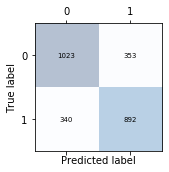

In [14]:
predicted = eclf.predict(X_test)
confmat = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=7)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('ConMatrix.png', dpi=600)
plt.show()

## Bagging

In [10]:
from sklearn.ensemble import BaggingClassifier

lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=nest, n_jobs=-1), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb.append(scores.mean())

lb2=[]    
print()
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=nest,max_features=0.35, n_jobs=-1), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb2.append(scores.mean())

Accuracy: 0.715 [1]
Accuracy: 0.712 [2]
Accuracy: 0.755 [5]
Accuracy: 0.769 [10]
Accuracy: 0.782 [20]
Accuracy: 0.787 [50]
Accuracy: 0.792 [100]
Accuracy: 0.795 [200]

Accuracy: 0.654 [1]
Accuracy: 0.647 [2]
Accuracy: 0.708 [5]
Accuracy: 0.723 [10]
Accuracy: 0.748 [20]
Accuracy: 0.770 [50]
Accuracy: 0.776 [100]
Accuracy: 0.783 [200]


## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

lrf=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(RandomForestClassifier(n_estimators=nest, n_jobs=-1), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lrf.append(scores.mean())

Accuracy: 0.709 [1]
Accuracy: 0.691 [2]
Accuracy: 0.755 [5]
Accuracy: 0.765 [10]
Accuracy: 0.778 [20]
Accuracy: 0.786 [50]
Accuracy: 0.793 [100]
Accuracy: 0.792 [200]


In [12]:
from sklearn.ensemble import ExtraTreesClassifier

lext=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(ExtraTreesClassifier(n_estimators=nest, n_jobs=-1), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lext.append(scores.mean())

Accuracy: 0.696 [1]
Accuracy: 0.683 [2]
Accuracy: 0.746 [5]
Accuracy: 0.759 [10]
Accuracy: 0.777 [20]
Accuracy: 0.782 [50]
Accuracy: 0.784 [100]
Accuracy: 0.789 [200]


## Boosting

In [13]:
from sklearn.ensemble import AdaBoostClassifier

lboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboo.append(scores.mean())

Accuracy: 0.727 [1]
Accuracy: 0.727 [2]
Accuracy: 0.734 [5]
Accuracy: 0.742 [10]
Accuracy: 0.753 [20]
Accuracy: 0.764 [50]
Accuracy: 0.773 [100]
Accuracy: 0.772 [200]


In [14]:
from sklearn.ensemble import AdaBoostClassifier

lboodt=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboodt.append(scores.mean())

Accuracy: 0.757 [1]
Accuracy: 0.762 [2]
Accuracy: 0.764 [5]
Accuracy: 0.761 [10]
Accuracy: 0.757 [20]
Accuracy: 0.736 [50]
Accuracy: 0.737 [100]
Accuracy: 0.729 [200]


In [15]:
from sklearn.ensemble import GradientBoostingClassifier

lgbboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(GradientBoostingClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lgbboo.append(scores.mean())

Accuracy: 0.694 [1]
Accuracy: 0.721 [2]
Accuracy: 0.772 [5]
Accuracy: 0.773 [10]
Accuracy: 0.771 [20]
Accuracy: 0.778 [50]
Accuracy: 0.787 [100]
Accuracy: 0.790 [200]


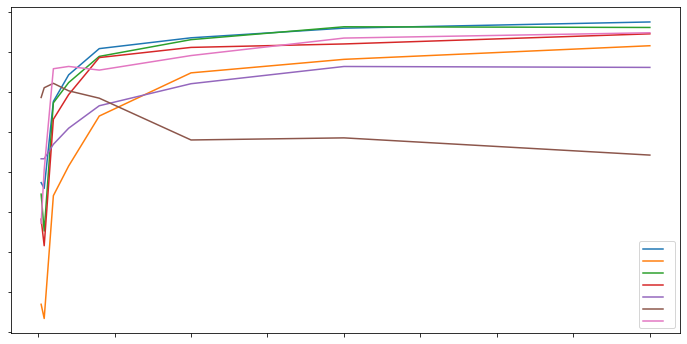

In [30]:
import  matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')

plt.show()

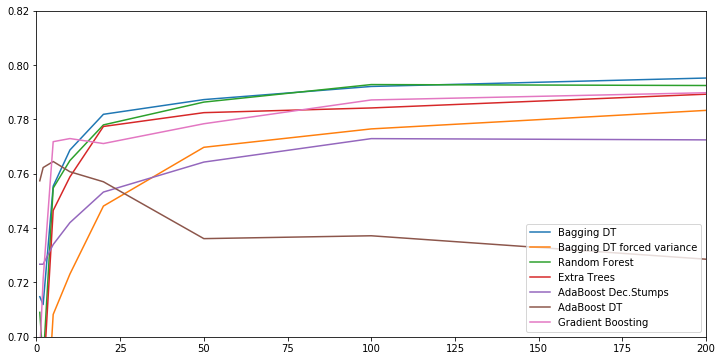

In [18]:
plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')
plt.xlim(0,200)
plt.ylim(0.70,0.82)
plt.show()

## Feature Selection with Forests of trees

In [20]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X, y)
print(clf.feature_importances_)  


[0.01961725 0.13720265 0.01499198 0.07276802 0.125569   0.048079
 0.0491907  0.02335224 0.06036377 0.00585969 0.04450077 0.05175204
 0.03099509 0.04030646 0.04236605 0.03937982 0.00406543 0.06461815
 0.07905791 0.04596397]


In [21]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, prefit=True, threshold=0.05)
X_new = model.transform(X)
print(X_new.shape)

print(np.mean(cross_val_score(KNeighborsClassifier(), X=X, y=y, cv=cv, scoring='accuracy')))
print(np.mean(cross_val_score(KNeighborsClassifier(), X=X_new, y=y, cv=cv, scoring='accuracy')))

(8692, 7)
0.7315622806268212
0.7552188957544348


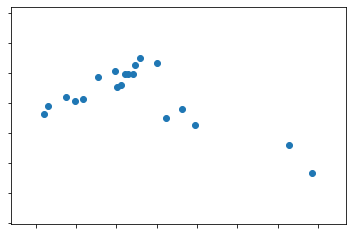

Best threshold:  0.051752036666449945


In [26]:
thresholds=clf.feature_importances_

l=[]
lparval=[]
for threshold in thresholds:
    model = SelectFromModel(clf, prefit=True, threshold=threshold)
    X_new = model.transform(X)
    params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
    knc = KNeighborsClassifier()
    clf2 = GridSearchCV(knc, param_grid=params,cv=cv)#,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
    clf2.fit(X, y)
    parval=clf2.best_params_
    clf3 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
    acc = np.mean(cross_val_score(clf3, X=X_new, y=y, cv=cv, scoring='accuracy'))
    l.append(acc)
    lparval.append(parval)
    
plt.scatter(thresholds,l)
plt.show()

print('Best threshold: ',thresholds[np.argmax(l)])

In [27]:
parval=lparval[np.argmax(l)]
model = SelectFromModel(clf, prefit=True, threshold=thresholds[np.argmax(l)])
X_new = model.transform(X)
print(X_new.shape)

print('Original: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X=X, y=y, cv=cv, scoring='accuracy')))
print('With FS: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights']), X=X_new, y=y, cv=cv, scoring='accuracy')))

(8692, 7)
Original:  0.7027013981035907
With FS:  0.7650823618743892
